## Imports

In [0]:
pip install catboost

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
import time
%matplotlib inline
# Classification
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
#import catboost as cat
from catboost import CatBoostRegressor

# Preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from mlxtend.classifier import StackingClassifier
from datetime import datetime, timedelta
from sklearn.naive_bayes import MultinomialNB

import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
# !pip install pycaret
# from pycaret.classification import *

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import *
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [0]:
test = pd.read_csv('/content/drive/My Drive/DS Projects/MH E commerce/Test.csv')
train = pd.read_csv('/content/drive/My Drive/DS Projects/MH E commerce/Train.csv')
print(test.shape,train.shape)

(1051, 7) (2452, 8)


In [0]:
train.head()

,Product,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Date,Selling_Price
0,P-2610,B-659,bags wallets belts,bags,hand bags,4.3,2/3/2017,291.0
1,P-2453,B-3078,clothing,women s clothing,western wear,3.1,7/1/2015,897.0
2,P-6802,B-1810,home decor festive needs,showpieces,ethnic,3.5,1/12/2019,792.0
3,P-4452,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,12/12/2014,837.0
4,P-8454,B-3078,clothing,men s clothing,t shirts,4.3,12/12/2013,470.0


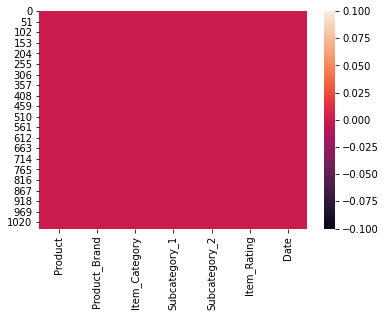

In [0]:
sns.heatmap(test.isnull())

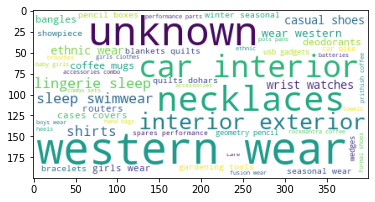

In [0]:
wc = WordCloud(background_color='white',
                    stopwords =  set(STOPWORDS),
                    max_words = 50, 
                    random_state = 42,)
wc.generate(' '.join(train['Subcategory_2']))
plt.imshow(wc)

In [0]:
df=train.append(test,ignore_index=True)
target = 'Selling_Price'

In [0]:
df.shape,df['Product'].nunique()

((3503, 8), 3503)

In [0]:
df['st_month'] = pd.to_datetime(df['Date']).dt.month
df['st_day'] = pd.to_datetime(df['Date']).dt.day
df['st_year'] = pd.to_datetime(df['Date']).dt.year
df['quarter'] =  pd.to_datetime(df['Date']).dt.quarter
df['semester'] = np.where(df.quarter.isin([1,2]),1,2)
df['dayofweek'] =  pd.to_datetime(df['Date']).dt.dayofweek
df['weekend'] = np.where(df['dayofweek'].isin([5,6]),1,0)
df.drop(columns = ['Product','Date'],inplace = True)

In [0]:
df.head()

,Product_Brand,Item_Category,Subcategory_1,Subcategory_2,Item_Rating,Selling_Price,st_month,st_day,st_year,quarter,semester,dayofweek,weekend
0,B-659,bags wallets belts,bags,hand bags,4.3,291.0,2,3,2017,1,1,4,0
1,B-3078,clothing,women s clothing,western wear,3.1,897.0,7,1,2015,3,2,2,0
2,B-1810,home decor festive needs,showpieces,ethnic,3.5,792.0,1,12,2019,1,1,5,1
3,B-3078,beauty and personal care,eye care,h2o plus eye care,4.0,837.0,12,12,2014,4,2,4,0
4,B-3078,clothing,men s clothing,t shirts,4.3,470.0,12,12,2013,4,2,3,0


In [0]:
df['BrandCategory'] = df['Product_Brand']+df['Item_Category']

In [0]:
l1 = df['Item_Category'].unique()#.head(30)

In [0]:
l2 = list(df[(~df['Item_Category'].duplicated(keep=False))]['Item_Category'])

In [0]:
categories = [x for x in l1 if x not in l2]

In [0]:
categories

['bags wallets belts',
 'clothing',
 'home decor festive needs',
 'beauty and personal care',
 'footwear',
 'kitchen dining',
 'automotive',
 'computers',
 'jewellery',
 'home furnishing',
 'pens stationery',
 'toys school supplies',
 'furniture',
 'mobiles accessories',
 'sunglasses',
 'cameras accessories',
 'baby care',
 'ebooks',
 'home improvement',
 'watches',
 'sports fitness',
 'eyewear',
 'tools hardware',
 'home entertainment',
 'pet supplies',
 'home kitchen',
 'gaming',
 'health personal care appliances']

In [0]:
for i in df['Item_Category'] :
  if i in list(df[(~df['Item_Category'].duplicated(keep=False))]['Item_Category']) :
    df.loc[df['Item_Category'] == i,'Item_Category'] = 'unknown'
    # df['Item_Category'] = ''
    # print(i)

In [0]:
df['Item_Category'].unique()

array(['bags wallets belts', 'clothing', 'home decor festive needs',
       'beauty and personal care', 'footwear', 'kitchen dining',
       'automotive', 'computers', 'unknown', 'jewellery',
       'home furnishing', 'pens stationery', 'toys school supplies',
       'furniture', 'mobiles accessories', 'sunglasses',
       'cameras accessories', 'baby care', 'ebooks', 'home improvement',
       'watches', 'sports fitness', 'eyewear', 'tools hardware',
       'home entertainment', 'pet supplies', 'home kitchen', 'gaming',
       'health personal care appliances'], dtype=object)

In [0]:
def feat_eng(df) :

#     #aggregate features
    cat_agg=['count','nunique']
    num_agg=['mean','min','max']
    num_agg1=['mean']
    agg_col={
        'Item_Rating':num_agg, 'Item_Category':cat_agg, 'Subcategory_1' : cat_agg, 'Subcategory_2' : cat_agg,}
        #'Selling_Price' : num_agg}

    agg_df=df.groupby('Product_Brand').agg(agg_col)
    agg_df.columns=['agg_' + '_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    df=df.merge(agg_df,on='Product_Brand',how='left')

    agg_df=df.groupby('BrandCategory').agg(agg_col)
    agg_df.columns=['BCagg_' + '_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    df=df.merge(agg_df,on='BrandCategory',how='left')
    
    agg_col={
        'Item_Rating':num_agg, 'Subcategory_1' : cat_agg, 'Subcategory_2' : cat_agg}

    agg_df=df.groupby('Item_Category').agg(agg_col)
    agg_df.columns=['Itagg_' + '_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    df=df.merge(agg_df,on='Item_Category',how='left')


    return df

In [0]:
df1 = feat_eng(df)
df = df1

In [0]:
df.columns

Index(['Product_Brand', 'Item_Category', 'Subcategory_1', 'Subcategory_2',
       'Item_Rating', 'Selling_Price', 'st_month', 'st_day', 'st_year',
       'quarter', 'semester', 'dayofweek', 'weekend', 'BrandCategory',
       'agg_Item_Rating_mean', 'agg_Item_Rating_min', 'agg_Item_Rating_max',
       'agg_Item_Category_count', 'agg_Item_Category_nunique',
       'agg_Subcategory_1_count', 'agg_Subcategory_1_nunique',
       'agg_Subcategory_2_count', 'agg_Subcategory_2_nunique',
       'BCagg_Item_Rating_mean', 'BCagg_Item_Rating_min',
       'BCagg_Item_Rating_max', 'BCagg_Item_Category_count',
       'BCagg_Item_Category_nunique', 'BCagg_Subcategory_1_count',
       'BCagg_Subcategory_1_nunique', 'BCagg_Subcategory_2_count',
       'BCagg_Subcategory_2_nunique', 'Itagg_Item_Rating_mean',
       'Itagg_Item_Rating_min', 'Itagg_Item_Rating_max',
       'Itagg_Subcategory_1_count', 'Itagg_Subcategory_1_nunique',
       'Itagg_Subcategory_2_count', 'Itagg_Subcategory_2_nunique'],
      d

In [0]:
#df = pd.get_dummies(df, columns = ['Product_Brand'])
df = pd.get_dummies(df, columns = ['Product_Brand','Item_Category', 'Subcategory_1', 'Subcategory_2','BrandCategory'])

## Data Prep


In [0]:
df_train=df[df[target].isnull()==False].copy()
df_test=df[df[target].isnull()==True].copy()
df_train = df_train.iloc[:-2]

df_test.drop(columns=[target],axis=1, inplace=True)

x = df_train.drop(target,axis=1)
y = df_train[target]
feat = df_test.columns

#x,y=smote.fit_sample(x,y)
#x, y= os.fit_sample(x, y)
print(x.shape,df_test.shape)

(2450, 3303) (1051, 3303)


In [0]:

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

In [0]:
def make_sub(y_pred,name):
    df_sub = pd.DataFrame({target : y_pred})
    #df_sub[target] = np.clip(df_sub[target], train[target].min(), train[target].max())
    import time
    times = time.strftime("%m-%d-")+'{:%H_%M_%S}'.format(datetime.now() + timedelta(hours=5.5))
    filename = 'submission-'+name+'_'+times+'.xlsx'
    df_sub.to_excel(filename, index=False)
    print(df_sub.head(5))
    print(f"{filename} generated!")

In [0]:
def model_run (model, metric) :
    err=[]
    y_pred_tot=[]
    x_pred_tot= pd.DataFrame()
    y_test_tot = pd.DataFrame()
    from sklearn.model_selection import KFold,StratifiedKFold
    
    
    fold=StratifiedKFold(n_splits=10,shuffle=True,random_state=1996)
    skf = fold.split(x,y)

    i=1

    for train_index, test_index in skf:
        print(f"\n\n-----------------FOLD {i}------------------------")
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        m=model
        #print(y_train.value_counts())
        if metric == 'none' :
            #m.fit(x_train,np.log(y_train),eval_set=[(x_test, np.log(y_test))],verbose=100, early_stopping_rounds=200)
            m.fit(x_train,np.log(y_train))
        else :
            m.fit(x_train,np.log(y_train),eval_set=[(x_test, np.log(y_test))],eval_metric=metric,verbose=100, early_stopping_rounds=200) #,categorical_feature = cat_feat)
        preds = np.exp(m.predict(x_test))
        #preds=np.asarray([np.argmax(line) for line in pr])
        #print(preds)
        print("err: ",rmse(np.log(y_test),np.log(preds)))
        err.append(rmse(np.log(y_test),np.log(preds)))
        p = np.exp(m.predict(df_test[feat]))
        #p = np.asarray([np.argmax(line) for line in p1])
        x_pred_tot[i] = preds
        y_test_tot[i] = y_test.values
        i=i+1
        y_pred_tot.append(p)
        
    print (f"Mean score : {np.mean(err,0)}")
    y_pred = np.mean(y_pred_tot, 0)
    x_pred = x_pred_tot.values.ravel()
    y_test = y_test_tot.values.ravel()
    return  y_test,x_pred,y_pred

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'max_depth':[10,12],
    'subsample':[0.8,0.9,1],
    'colsample_bytree': [0.4,0.5,0.6],
    'min_child_weight': [0.5,1],
    'gamma': [0,1]
}

k = StratifiedKFold(n_splits=4)

xgb = XGBRegressor(n_jobs=4, n_estimators=1000, learning_rate=0.05,  tree_method = "gpu_hist")
xgb_grid = GridSearchCV(xgb, param_grid, cv=k, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=4)
xgb_grid.fit(x, y)

Fitting 4 folds for each of 72 candidates, totalling 288 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 11.2min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 48.8min
[Parallel(n_jobs=4)]: Done 288 out of 288 | elapsed: 74.7min finished


[10:45:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.05,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=1000, n_jobs=4, nthread...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, tree_method='gpu_hist',
                                    verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6], 'gamma': [0, 1],
                         'max_depth': [10, 12], 'min_child_weig

In [0]:
#xgb_best = xgb_grid.best_estimator_
xgb = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.05, colsample_bytree=0.5, tree_method = "gpu_hist")

In [0]:
y_test_xgb,x_preds_xgb,y_preds_xgb = model_run(xgb, 'rmse') 



-----------------FOLD 1------------------------
[15:56:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.9901
Will train until validation_0-rmse hasn't improved in 200 rounds.


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


[100]	validation_0-rmse:0.595949
[200]	validation_0-rmse:0.602998
[300]	validation_0-rmse:0.613064
Stopping. Best iteration:
[107]	validation_0-rmse:0.595155

err:  0.5951546612719025


-----------------FOLD 2------------------------
[15:56:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:6.00139
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:0.723117
[200]	validation_0-rmse:0.700686
[300]	validation_0-rmse:0.714565
Stopping. Best iteration:
[186]	validation_0-rmse:0.698592

err:  0.6985920060733379


-----------------FOLD 3------------------------
[15:56:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5.90949
Will train until validation_0-rmse hasn't improved in 200 rounds.
[100]	validation_0-rmse:0.670545
[200]	validation_0-rmse:0.659282
[300]	validation_0-r

In [0]:
rmse(np.log(y_test_xgb),np.log(x_preds_xgb))

0.6569733883781339

In [0]:
make_sub(y_preds_xgb,'xgb')

   Selling_Price
0    2577.482422
1     438.965881
2     719.418823
3     358.112000
4     675.059265
submission-xgb_agg_f_06-14-21_27_48.xlsx generated!
